In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

# Add current directory to path to import readBLOT
sys.path.append(os.getcwd())
try:
    from readBLOT import read_blot_data
except ImportError:
    # Fallback if running relative
    sys.path.append('.')
    from readBLOT import read_blot_data

sns.set_theme(style="whitegrid")

In [2]:
# Load Data
df = read_blot_data('blot.txt')
print(f"Data Loaded: {df.shape}")
print(df.head())

# Identify item columns (exclude PersonID if present)
# Based on readBLOT.py behavior in previous turns, it likely returns a DataFrame with 'PersonID' and items.
item_cols = [c for c in df.columns if c != 'PersonID']
print(f"Number of Items: {len(item_cols)}")

Data Loaded: (150, 36)
  PersonID  1_Negation  2_Reciproc  3_Implicat  4_Incompat  5_MultComp  \
0      001           1           1           1           1           1   
1      002           1           1           1           1           1   
2      003           1           1           0           1           0   
3      004           1           1           1           1           1   
4      005           1           1           1           1           1   

   6_Correlat  7_Correlat  8_Correlat  9_Conjunct  ...  26_ComplAff  \
0           1           1           1           1  ...            1   
1           1           1           1           1  ...            1   
2           1           1           1           1  ...            1   
3           1           1           1           1  ...            1   
4           1           1           1           1  ...            1   

   27_Neg of p  28_Non-impl  29_Aff of q  30_Equiv  31_Neg of q  \
0            1            1           

In [3]:
# Debugging Score Calculation
# Check if selecting by column list with duplicate names causes issues
selected_cols = df[item_cols]
print(f"Original DataFrame Shape: {df.shape}")
print(f"Item Columns List Length: {len(item_cols)}")
print(f"Shape of df[item_cols]: {selected_cols.shape}")

# Check sum stats
raw_sums = selected_cols.sum(axis=1)
print(f"Max Score by name selection: {raw_sums.max()}")

# Alternative: Select by logical exclusion of PersonID (if it's the first column, or by index)
# Assuming PersonID is column 0
items_by_pos = df.iloc[:, 1:]
print(f"Shape of df.iloc[:, 1:]: {items_by_pos.shape}")
print(f"Max Score by position: {items_by_pos.sum(axis=1).max()}")

Original DataFrame Shape: (150, 36)
Item Columns List Length: 35
Shape of df[item_cols]: (150, 35)
Max Score by name selection: 35
Shape of df.iloc[:, 1:]: (150, 35)
Max Score by position: 35


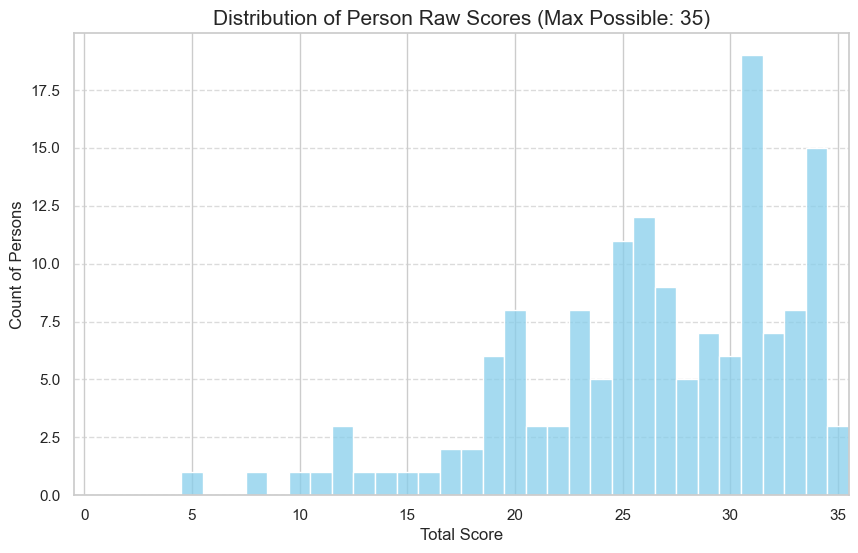

In [4]:
# Plot 1: Person Scores Distribution
# Calculate scores using positional indexing to avoid duplicate column name issues
person_scores = df.iloc[:, 1:].sum(axis=1)

# Theoretical max score is number of items
max_score = df.shape[1] - 1

plt.figure(figsize=(10, 6))
# Histogram with discrete bins
sns.histplot(person_scores, discrete=True, color='skyblue', binrange=(0, max_score))
plt.title(f'Distribution of Person Raw Scores (Max Possible: {max_score})', fontsize=15)
plt.xlabel('Total Score')
plt.ylabel('Count of Persons')

# Set X-axis to cover full potential range [0, 35]
plt.xlim(-0.5, max_score + 0.5)
plt.xticks(range(0, max_score + 1, 5)) # Tick every 5 units

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Items by position: 35
Scores Length: 35


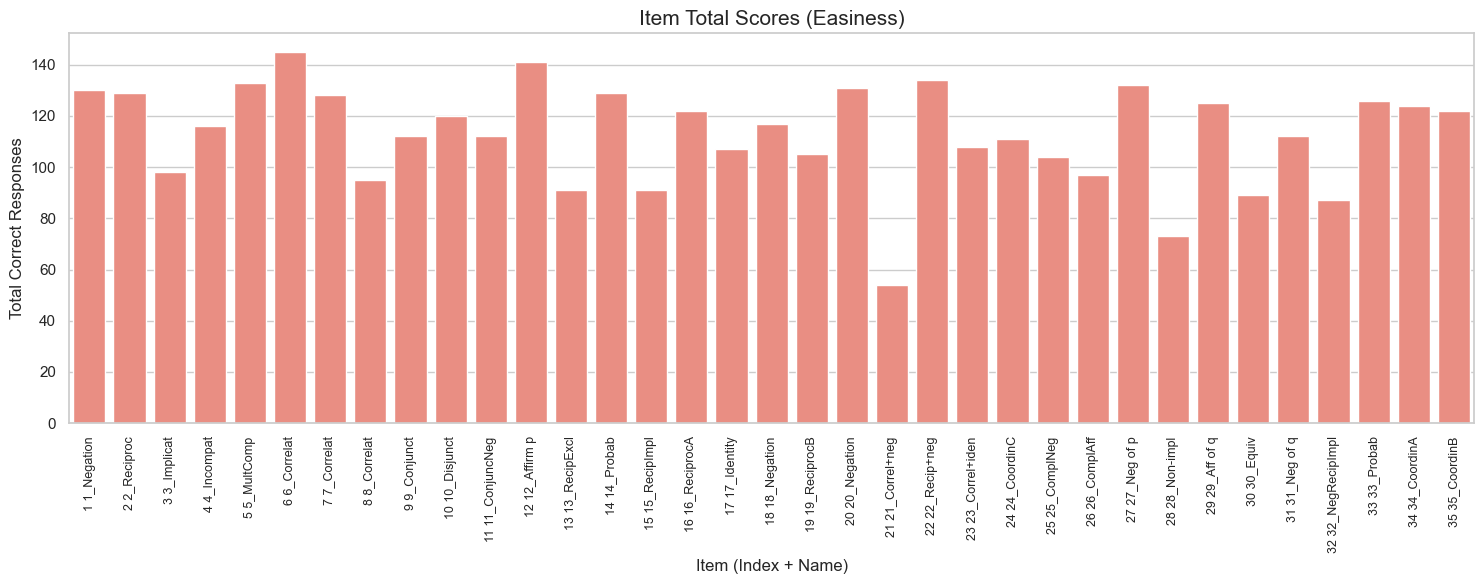

In [5]:
# Plot 2: Item Scores Distribution
# Use iloc to avoid issues with duplicate column names
# Assuming first column is ID and rest are items.
item_data = df.iloc[:, 1:] 
item_scores = item_data.sum(axis=0)

num_items = item_data.shape[1]
print(f"Items by position: {num_items}")
print(f"Scores Length: {len(item_scores)}")

# Create labels with "Index Name" format
item_names = item_data.columns
item_labels = [f"{i+1} {name}" for i, name in enumerate(item_names)]

# Create DataFrame for plotting
plot_df = pd.DataFrame({
    'ItemIndex': range(num_items),
    'Score': item_scores.values
})

plt.figure(figsize=(15, 6))
sns.barplot(data=plot_df, x='ItemIndex', y='Score', color='salmon')

# Set X-Ticks
plt.xticks(
    ticks=range(num_items), 
    labels=item_labels, 
    rotation=90, 
    ha='center',
    fontsize=9
)

plt.title('Item Total Scores (Easiness)', fontsize=15)
plt.xlabel('Item (Index + Name)')
plt.ylabel('Total Correct Responses')
plt.tight_layout()
plt.show()

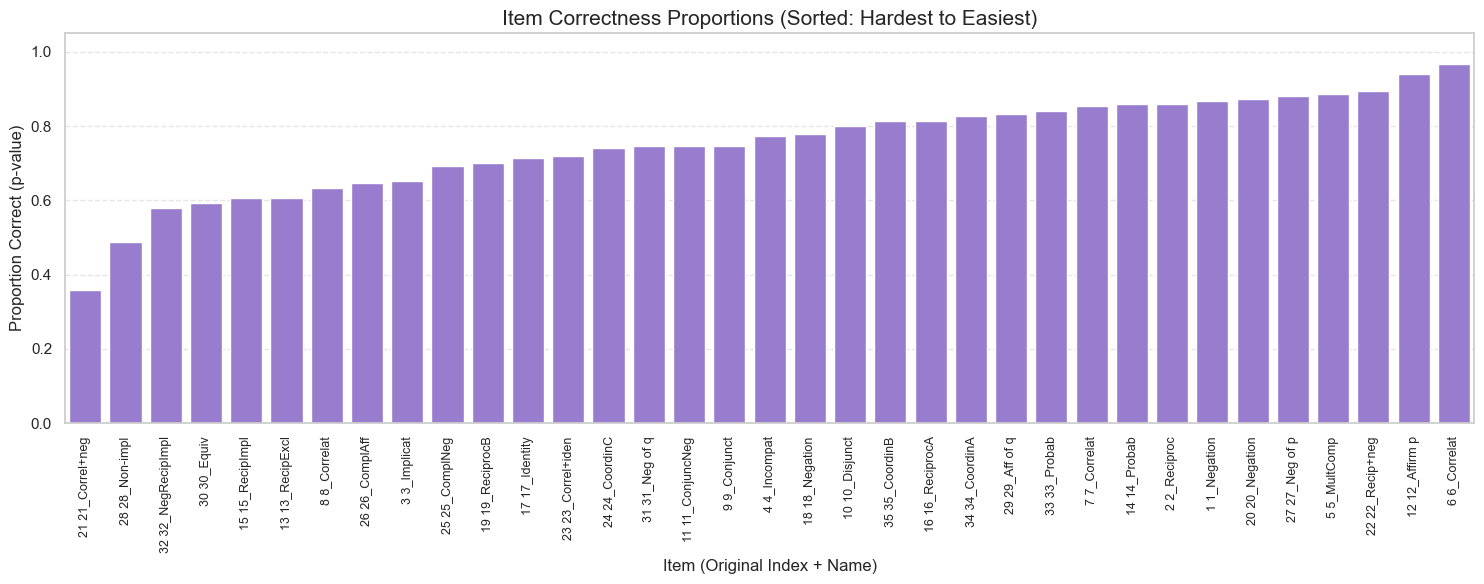

In [6]:
# Plot 3: Item Scores (Sorted by Difficulty/Easiness) as Proportions
# Calculate proportions
n_persons = df.shape[0]
item_data = df.iloc[:, 1:]
item_props = item_data.sum(axis=0) / n_persons

# Create DataFrame for sorting
# Sort by Proportion Ascending (Lowest/Hardest on Left -> Highest/Easiest on Right)
item_df_sorted = pd.DataFrame({
    'OriginalIndex': range(1, len(item_props) + 1),
    'Name': item_data.columns,
    'Proportion': item_props.values
}).sort_values('Proportion')

# Create labels for the sorted x-axis
labels_sorted = [f"{row.OriginalIndex} {row.Name}" for _, row in item_df_sorted.iterrows()]

plt.figure(figsize=(15, 6))
# Plot bars in the sorted order
sns.barplot(x=list(range(len(item_props))), y=item_df_sorted['Proportion'], color='mediumpurple')

# Set X-Ticks
plt.xticks(
    ticks=range(len(item_props)), 
    labels=labels_sorted, 
    rotation=90, 
    ha='center',
    fontsize=9
)

plt.title('Item Correctness Proportions (Sorted: Hardest to Easiest)', fontsize=15)
plt.xlabel('Item (Original Index + Name)')
plt.ylabel('Proportion Correct (p-value)')
plt.ylim(0, 1.05) 
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

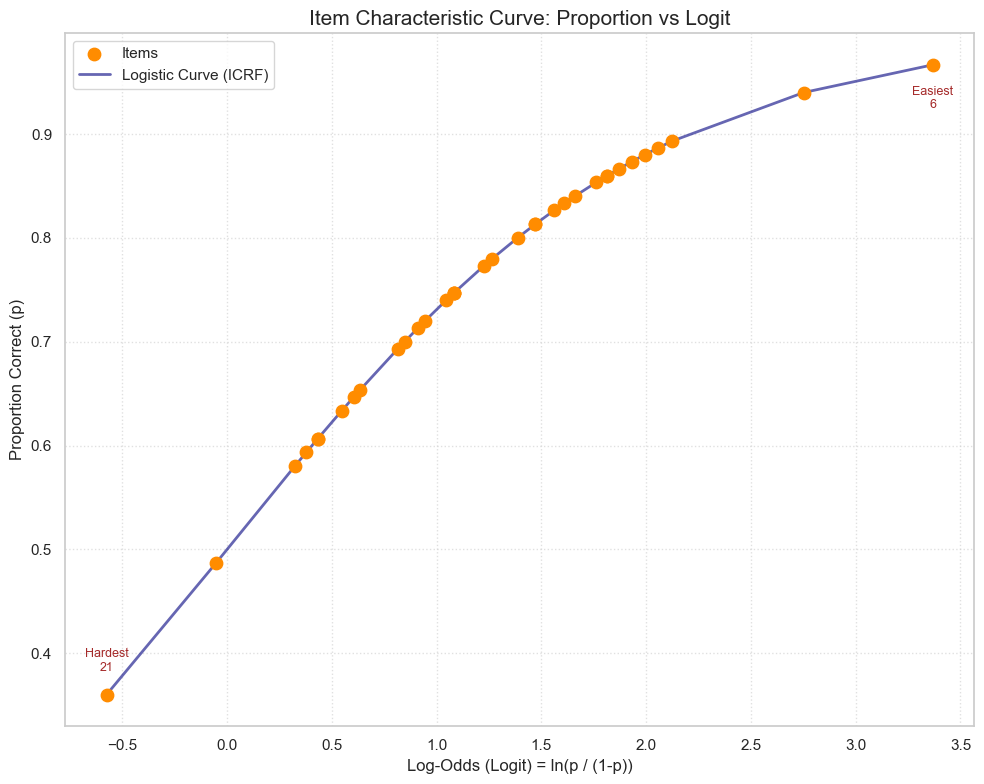

In [7]:
# Plot 4: Proportion Correct vs Log-Odds (The Logistic Curve)
import numpy as np # Ensure numpy is imported

# This plot visualizes the transformation from logit scale to proportions (Logistic Curve).
# X-Axis: Log-Odds / Difficulty
# Y-Axis: Probability / Proportion

# Use the sorted item dataframe from previous step
p = item_df_sorted['Proportion'].clip(0.001, 0.999) 
q = 1 - p
logits = np.log(p / q)

plt.figure(figsize=(10, 8))

# Plot Points (Swapped Axes)
plt.scatter(logits, p, color='darkorange', s=80, label='Items', zorder=5)

# Connect consecutive points
plt.plot(logits, p, color='navy', linestyle='-', linewidth=2, alpha=0.6, label='Logistic Curve (ICRF)')

# Annotation for specific items
# Hardest (First in sorted -> Lowest Prop -> Lowest Logit)
# Position text relative to the point
plt.text(logits.iloc[0], p.iloc[0] + 0.02, f"Hardest\n{item_df_sorted.iloc[0]['OriginalIndex']}", 
         ha='center', va='bottom', fontsize=9, color='brown')

# Easiest (Last in sorted -> Highest Prop -> Highest Logit)
plt.text(logits.iloc[-1], p.iloc[-1] - 0.02, f"Easiest\n{item_df_sorted.iloc[-1]['OriginalIndex']}", 
         ha='center', va='top', fontsize=9, color='brown')

plt.title('Item Characteristic Curve: Proportion vs Logit', fontsize=15)
plt.xlabel('Log-Odds (Logit) = ln(p / (1-p))')
plt.ylabel('Proportion Correct (p)')
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

Stats for Item 21 around Score 15:
    TotalScore  ProportionCorrect  N       std
2           10           0.000000  1       NaN
3           11           0.000000  1       NaN
4           12           0.333333  3  0.577350
5           13           0.000000  1       NaN
6           14           0.000000  1       NaN
7           15           1.000000  1       NaN
8           16           0.000000  1       NaN
9           17           0.000000  2  0.000000
10          18           0.500000  2  0.707107
11          19           0.333333  6  0.516398
12          20           0.000000  8  0.000000


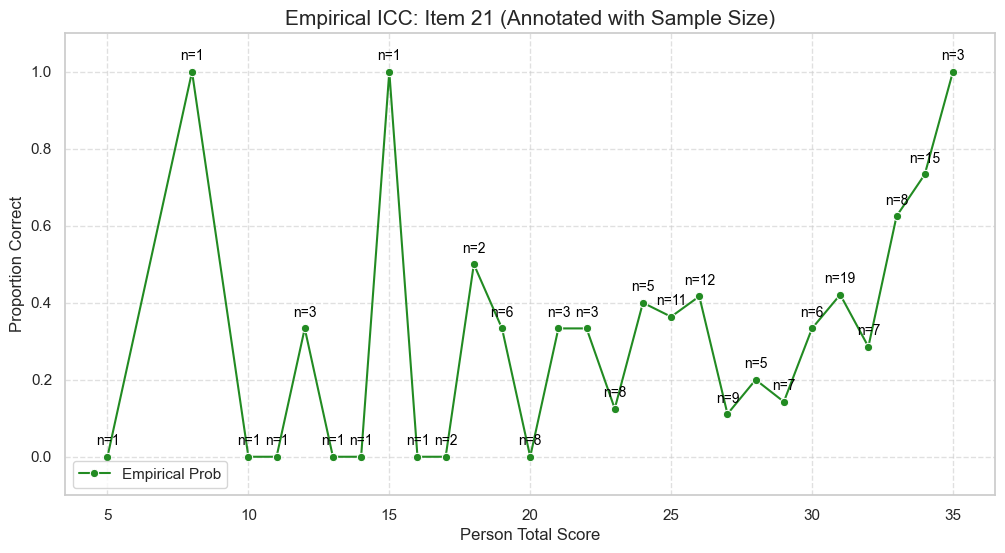

In [8]:
# Plot 7: Investigation of Item 21 Empirical ICC (annotated with Sample Size)
# User noticed an anomaly at Total Score 15 (Proportion = 1.0).
# Let's check the sample size at each score level.

target_item_idx = 21
item_responses = df.iloc[:, target_item_idx]
person_total_scores = df.iloc[:, 1:].sum(axis=1)

icc_df_21 = pd.DataFrame({
    'TotalScore': person_total_scores,
    'Response': item_responses
})

# Aggegate
grouped_icc_21 = icc_df_21.groupby('TotalScore')['Response'].agg(['mean', 'count', 'std']).reset_index()
grouped_icc_21 = grouped_icc_21.rename(columns={'mean': 'ProportionCorrect', 'count': 'N'})

print(f"Stats for Item {target_item_idx} around Score 15:")
print(grouped_icc_21[ (grouped_icc_21['TotalScore'] >= 10) & (grouped_icc_21['TotalScore'] <= 20) ])

plt.figure(figsize=(12, 6))
# Plot line
sns.lineplot(data=grouped_icc_21, x='TotalScore', y='ProportionCorrect', marker='o', color='forestgreen', label='Empirical Prob')

# Add text annotations for sample size (N) at each point
for index, row in grouped_icc_21.iterrows():
    plt.text(row['TotalScore'], row['ProportionCorrect'] + 0.03, f"n={int(row['N'])}", 
             ha='center', fontsize=10, color='black')

plt.title(f'Empirical ICC: Item {target_item_idx} (Annotated with Sample Size)', fontsize=15)
plt.ylabel('Proportion Correct')
plt.xlabel('Person Total Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim(-0.1, 1.1)
plt.legend()
plt.show()

### Corrected Item-Total Correlations (Discrimination)

*   **What it is:** The correlation between how a person answered a specific item and their total score on _all other_ items.
*   **Why it helps:** This is a proxy for item discrimination. High correlation means the item discriminates well between high and low ability students. Low (or negative) correlation suggests the item might be confusing, miskeyed, or measuring a different construct.

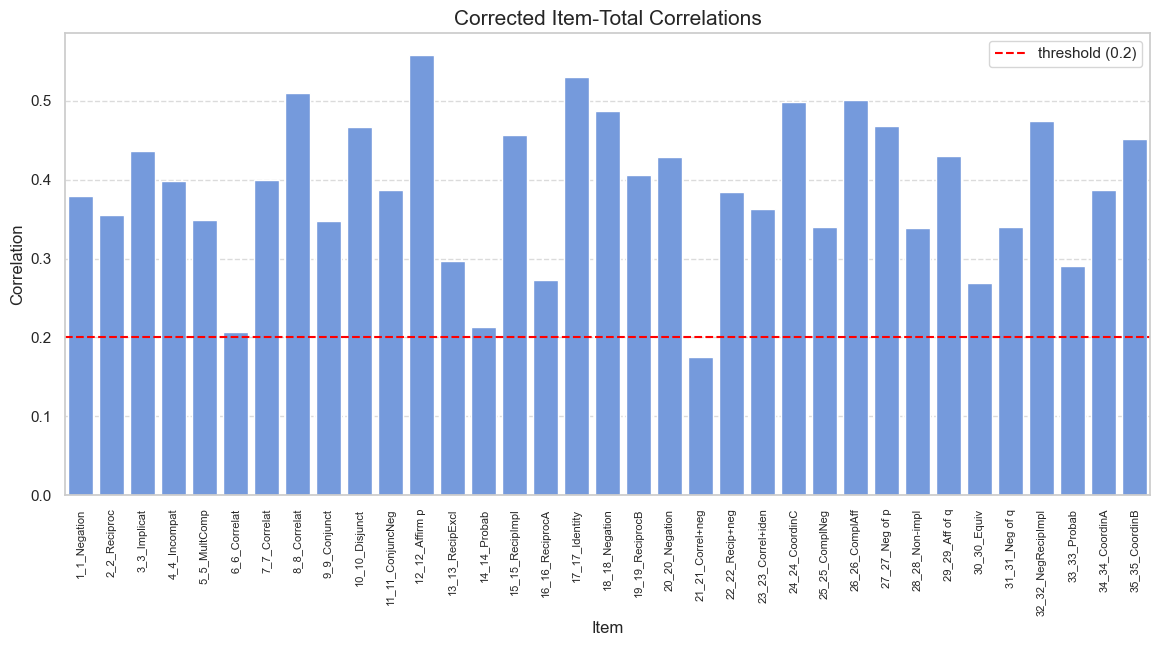

Items with low discrimination (< 0.2):
                Item  Correlation
20  21_21_Correl+neg     0.175688


In [9]:
# Plot 9: Item-Total Correlations (Discrimination)
# We calculate the correlation between each item and the total score.
# Ideally, we use "Corrected Item-Total Correlation" (Total Score excluding the item itself)
# to avoid inflating the correlation.

correlations = []
# Use iloc to handle potential duplicate column names safely
item_data_only = df.iloc[:, 1:] 
n_items = item_data_only.shape[1]

# Calculate total score of all items first
all_items_total = item_data_only.sum(axis=1)

for col_idx in range(n_items):
    # Select by position to avoid duplicate name issues
    item_responses = item_data_only.iloc[:, col_idx]
    item_name = item_data_only.columns[col_idx]
    
    # Calculate corrected total: Total - Item Score
    corrected_total = all_items_total - item_responses.fillna(0)
    
    # Check if item is constant (variance 0) to avoid NaN
    if item_responses.std() == 0:
        corr = 0
    else:
        corr = item_responses.corr(corrected_total)
    
    # Use index + name for clearer label
    label = f"{col_idx+1}_{item_name}"
    correlations.append({'Item': label, 'Correlation': corr})

corr_df = pd.DataFrame(correlations)

# Plot
plt.figure(figsize=(14, 6))

sns.barplot(data=corr_df, x='Item', y='Correlation', color='cornflowerblue')
plt.title('Corrected Item-Total Correlations', fontsize=15)
plt.axhline(0.2, color='red', linestyle='--', label='threshold (0.2)') # Common cutoff

# Set X-labels
plt.xticks(
    rotation=90, 
    fontsize=8
)
plt.xlabel("Item")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

# List items with low discrimination
low_discrim = corr_df[corr_df['Correlation'] < 0.2]
if not low_discrim.empty:
    print("Items with low discrimination (< 0.2):")
    print(low_discrim)
else:
    print("All items have discrimination > 0.2")

### Guttman Scalogram (Response Matrix Heatmap)

*   **What it is:** A heatmap of the raw data, sorted by Person Score (rows) and Item Difficulty (columns).
*   **Why it helps:** In a perfect Guttman scale, you should see a "triangular" pattern of correct responses (1s) in the top-left and incorrect responses (0s) in the bottom-right. Deviations (like 0s in the sea of 1s or 1s in the sea of 0s) highlight "unexpected" responses or misfitting items/persons.

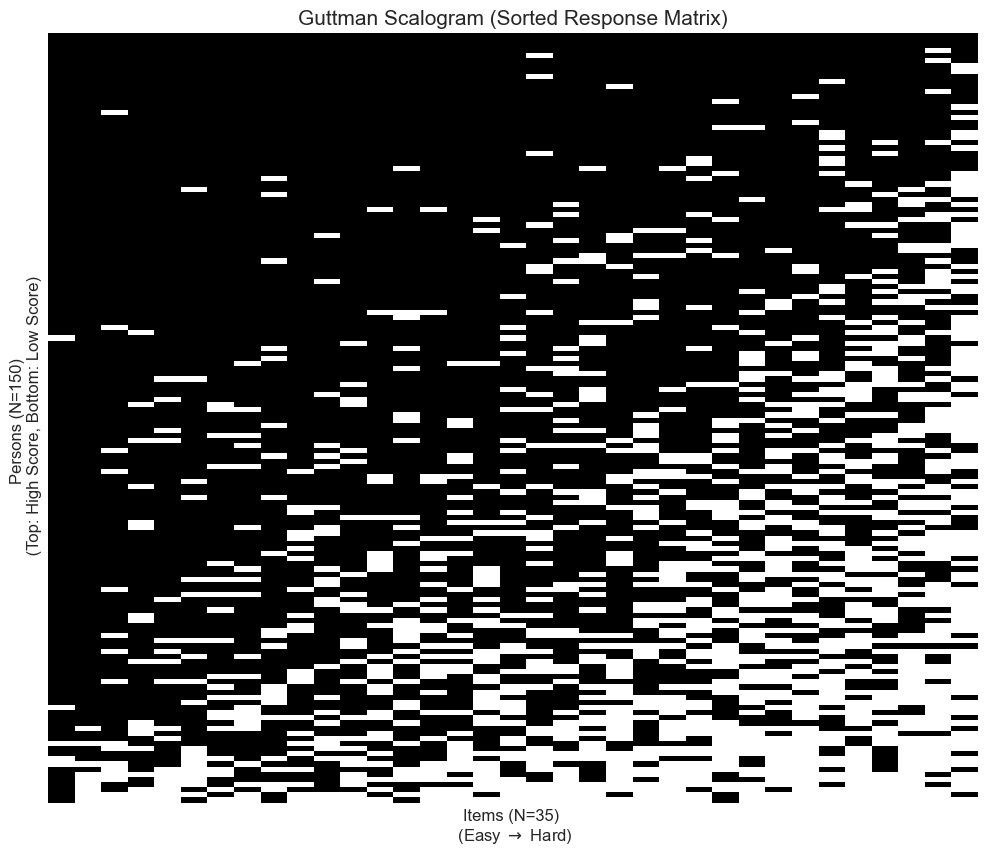

In [30]:
# Plot 8: Guttman Scalogram (Response Matrix Heatmap)
# Sort persons by total score (descending) and items by correctness (descending)
# This visualization helps check for the Guttman pattern (triangle of 1s in top-left)
# and identify unexpected response patterns.

# 1. Prepare Data
# Ensure we strictly select the 35 items (Columns 1 to 35)
# This safeguards against any extra columns that might be present in the DataFrame
response_matrix = df.iloc[:, 1:36].copy() 

person_scores = response_matrix.sum(axis=1)
item_difficulties = response_matrix.mean(axis=0) # Measure as proportion correct (easiness)

# 2. Sort
# Sort persons: highest score first
sorted_persons_idx = person_scores.sort_values(ascending=False).index
response_matrix_sorted = response_matrix.loc[sorted_persons_idx]

# Sort items: easiest (highest mean) first
sorted_items_idx = item_difficulties.sort_values(ascending=False).index
response_matrix_sorted = response_matrix_sorted[sorted_items_idx]

# 3. Plot
plt.figure(figsize=(12, 10))
sns.heatmap(response_matrix_sorted, 
            cbar=False, 
            cmap="Greys", 
            xticklabels=False, 
            yticklabels=False)

plt.title('Guttman Scalogram (Sorted Response Matrix)', fontsize=15)
plt.ylabel(f'Persons (N={len(response_matrix_sorted)}) \n (Top: High Score, Bottom: Low Score)')
plt.xlabel(f'Items (N={response_matrix_sorted.shape[1]}) \n (Easy $\\rightarrow$ Hard)')
plt.show()

In [28]:
response_matrix_sorted.iloc[-1,:].sum()

5